In [453]:
import os
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, BatchNormalization, Flatten, Reshape, Concatenate, GRU, LSTM, SimpleRNN , Lambda

In [454]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import Sequence

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, df, group_column, output_column, column_order, batch_size, k, subseq_generator_type = "rand"):
        #Paper's parameters for subseq generating
        self.k = k
        self.batch_size = batch_size
        self.subseq_generator_type = subseq_generator_type
        
        #General parameters
        self.df = df
        self.group_column = group_column
        self.column_order = column_order
        self.output_column = output_column
    
        #Get distinc id for train test val
        self.train_val_test_id_supervised()
        
        #Get dataframes for train, test val
        self.train_val_test_df_supervised()
        
        #Get self supervised data
        self.ssl_data()
        
        #Group and save data in seperate folder based on ID
        self.group_save_by_id()
        
        #Vocab_ids
        self.generate_vocab_map()
        #Set mode for data generator
        self.supervised = False
        
    def generate_vocab_map(self):
        self.vocab_map = {}
        #Iterate over categoricals and create map for value -> id
        for column in self.column_order["categoricals"].key():
            cardinality = set(self.df[column])
            
            card_id = {}
            #generate val -> id
            for i, value in enumerate(cardinality):
                card_id[value] = i
            self.vocab_map[column] = card_id
            
    def group_by_id_save(self):
        os.mkdir("ssl_data")
        #Group by and save data to read in future
        for index, df in self.ssl_df.groupby(self.group_column):
            dest_path = "ssl_data/{}.csv".format(index)
            os.mkdir(dest_path)
            df.to_csv(dest_path, indexes=False)
        
    def find_treshold_supervised(self):
        #Get treshold to split data into train and test for supervised learning
        self.ids_supervised = list(set(self.labeld_df[self.group_column]))
        self.treshold = int(len(self.ids_supervised)) * 0.1
        
    def train_val_test_id_supervised(self):
        #Get only labeld data
        self.labeld_df = self.df.loc[~self.df[self.output_column].isna()]
        #Get treshold for train and test 
        self.find_treshold_supervised()
        
        #Get train Ids
        self.train_id_supervised = self.ids_supervised[self.treshold:]
        
        #Split train id between train and validation
        valid_treshold = int(len(self.train_id_supervised)) * 0.1
        self.val_id_supervised = self.train_id_supervised[:valid_treshold]
        self.train_id_supervised = self.train_id_supervised[valid_treshold:]
        
        #Get test id
        self.test_id_supervised  = self.ids_supervised[:self.treshold]
    
    def ssl_data(self):
        #Skip labeld test and validation dat
        self.ssl_df = self.df.loc[~self.df[self.group_column].isin(self.val_id_supervised +  self.test_id_supervised)].drop([self.output_column])
        #unique ids for slef supervised learning
        self.ssl_id = list(set(ssl_df[self.group_column]))
    
    def set_mod(self, supervised):
        #Data generation mod
        self.supervised = supervised
       
    def train_val_test_df_supervised(self):
        #Split data for supervised manner
        self.train_df_supervised = self.df.loc[self.df[self.group_column].isin(self.train_id_supervised)]
        self.val_df_supervised = self.df.loc[self.df[self.group_column].isin(self.val_id_supervised)]
        self.test_df_supervised = self.df.loc[self.df[self.group_column].isin(self.test_id_supervised)]
    
    def __len__(self):
        #Get length of iterations, based on type of task. SSL or supervised
        length = len(self.train_id_supervised) if self.supervised else self.ssl_df.shape[0]
        length = int(np.floor(length / self.batch_size))
        return length
    
    def on_epoch_end(self):
        if self.supervised:
            np.random.shuffle(self.train_id_supervised)
        else:
            np.random.shuffle(self.ssl_id)
        
    def encode_pair_make_input(self, pair):
        pair_0 = []
        pair_1 = []
        
        #Iterate over columns and encode
        for cat_column in self.column_order["categoricals"].key():
            categorcial_encodings_0 = []
            categorcial_encodings_1 = []
            #Iterate over events
            for j in range(self.k):
                #Get value for first element of pair and encode
                categorcial_value_0 = pair[0][cat_column][i]
                encoded_0 = self.vocab_map[cat_column][categorcial_value]
                
                #Get value for second element of pair and encode
                categorcial_value_1 = pair[1][cat_column][i]
                encoded_1 = self.vocab_map[cat_column][categorcial_value]
                
                #Store encoded values
                categorcial_encodings_0.append(encoded_0)
                categorcial_encodings_1.append(encoded_1)
            
            #Store list of encoded values of catogrical feature 
            pair_0.append(np.asarray(categorcial_encodings_0))
            pair_1.append(np.asarray(categorcial_encodings_1))
            
        for numerical_column in self.column_order["numerical"].key():
            numerical_0 = []
            numerical_1 = []
            for j in range(self.k):
                #Get nuemrical value
                numerical_value_0 = float(pair[0][numerical_column][i])
                numerical_value_1 = #float(pair[1][numerical_column][i])
                #Store numerical value
                numerical_0.append(numerical_value_0)
                numerical_1.append(numerical_value_1)
                
            #Reshape for network input
            numerical_0 = np.asarray(numerical_0).reshape((1, self.k, 1))
            numerical_1 = np.asarray(numerical_1).reshape((1, self.k, 1))

            #Store list of numerical values of feature 
            pair_0.append(np.asarray(numerical_0))
            pair_1.append(np.asarray(numerical_1))
        #To numpy
        pair_0 = np.asarray(pair_0)
        pair_1 = np.asarray(pair_1)
        
        return pair_0 + pair_1 
    
    def __getitem__(self, index):
        #Get ids based n training type
        ids = self.ssl_id if self.supervised else self.train_id_supervised
        #Get batch ids
        start = index * self.batch_size
        id_batch = ids[start: start + self.batch_size]
        
        if slef.supervised:
            pass
        else:
            sequances = []
            
            for id in id_batch:
                df = pd.read_csv("ssl_data/{}.csv".format(id)).head(self.k)
                positive = random.randint(0,1)
                sequances.append((df, positive))
            
            #TODO: Create pair generation
            pairs = []
                           
            #batch input
            x = []
            y = []
            #encode pairs
            for pair in pairs:
                x.append(self.encode_pair_make_input(pair[0]))
                y.append(pair[1])
            return np.asarray(x), np.asarray(y)
            

In [361]:
class CoLES(object):
    def __init__(self, 
                 categorical_embeddings_info, 
                 numerical_variables_info, 
                 input_length=7,
                 rnn_type="simple",
                 rnn_units = 64,
                 **kwargs):
        super(CoLES, self).__init__(**kwargs)
        
        #For storing intermediate layers for calling from call() method
        self.inputs = {"input_0":{}, "input_1":{}}
        self.embeddings = {}
        self.batch_norms = {}
        
        #Inputs info . E.g embeddings sizes per categorcial features and names of numerical variables
        self.categorcial_embeddigs_info = categorical_embeddings_info
        self.numerical_variables = numerical_variables_info
        self.input_length = input_length
        #Add categorcial embeddings
        self.add_embeddings_batchNorm_layers(categorcial=True)
        #Add numerical inputs with batch normalizations
        self.add_embeddings_batchNorm_layers(categorcial=False)
        #Concat layer
        self.concat = Concatenate(axis=-1)
        #Encoder
        self.rnn = self.getRNN(rnn_type, rnn_units)
        #Distance layer
        self.l2 = Lambda(self.l2)
        self.build_model()
        
    def build_model(self):
        x = [[],[]]
        inputs = []
        
        #Evaluate inputs for input branch 1 and 2.
        #Iterate over each branch
        for i, input_path in enumerate(self.inputs.keys()):
            #Iterate over current branchs inputs to evaluate and store result
            for j, input_key in enumerate(self.inputs[input_path].keys()):
                x[i].append(self.inputs[input_path][input_key])
                inputs.append(self.inputs[input_path][input_key])
        
        #Evaluate embeddings for categorical inputs       
        for i in range(len(self.inputs)):
            #Iterate over embeddings, evaluate and store
            for j, embedding_key in enumerate(self.embeddings.keys()):
                x[i][j] = self.embeddings[embedding_key](x[i][j])
                
        #Evaluate batch normalization for numerical inputs       
        for i in range(len(self.inputs)):
            #Iterate over batch normalizations and evaluate
            for j, numerical_key in enumerate(self.batch_norms.keys()):
                #Get index for numerical as we store in list categoricals as well
                numerical_index = j + len(self.embeddings)
                x[i][numerical_index] = self.batch_norms[numerical_key](x[i][numerical_index])
        
        #Concatination of embeddings and normalized nuemricals
        concat_0 = self.concat(x[0])
        concat_1 = self.concat(x[1])
        
        #Encoders
        encoder_0 = self.rnn(concat_0)
        encoder_1 = self.rnn(concat_1)
        
        #L2 distance calculation
        l2_distance = self.l2([encoder_0, encoder_1])
        self.model = Model(inputs=inputs,outputs=l2_distance)

    #L2 distance function for lambda layer
    def l2(self, vectors):
        x, y = vectors
        return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    
    #Returns rnn based on type
    def getRNN(self, rnn_type, units):
        if "simple" == rnn_type:
            return SimpleRNN(units)
        elif "lstm" == rnn_type:
            return LSTM(units)
        elif "gru" == rnn_type:
            return GRU(units)
        
    #Adds inputs, and based on variable type or embedding or bach normalization layer
    def add_embeddings_batchNorm_layers(self, categorcial):
        #Get categorcial or numerical feature information
        feature_names = self.categorcial_embeddigs_info.keys() if categorcial else self.numerical_variables
        
        #Iterate over features and create inputs for each one
        #based on feature type create embedding or batch normalization layer
        for var_name in feature_names:
            
            #Postfix of input key
            postfix = "categorcial" if categorcial else "numerical"
            postfix = postfix + "_{}".format(var_name)
            
            #Name of input layer
            input_key_0 = "input_0_{}".format(postfix)
            input_key_1 = "input_1_{}".format(postfix)
            
            #Input dim based on feature type
            input_dim = self.input_length if categorcial else (self.input_length,1)
            #Inputs
            input_0 = Input(input_dim, name=input_key_0)
            input_1 = Input(input_dim, name=input_key_1)
            
            #Store inputs for calling from call() method
            self.inputs["input_0"][input_key_0] = input_0
            self.inputs["input_1"][input_key_1] = input_1
            
            #Create embedding and store
            if (categorcial):
                #Embedding layer
                vocab_size = self.categorcial_embeddigs_info[var_name][0]
                embedding_dim = self.categorcial_embeddigs_info[var_name][1]
                categorcial_embedding = Embedding(vocab_size, embedding_dim,input_length = self.input_length, name="embedding_{}".format(var_name))
                self.embeddings[var_name] = categorcial_embedding
            #Create BatchNormalization layer
            else:
                #Batch normalization
                btch_norm = BatchNormalization()
                self.batch_norms[var_name] = btch_norm

In [362]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [374]:
categorcial = {
    "MCC":[500,400]}
numerical = ["amount","count"]
coles = CoLES(categorcial, numerical)

In [442]:
coles.model.compile(loss=contrastive_loss, optimizer="adam",metrics=['accuracy'])

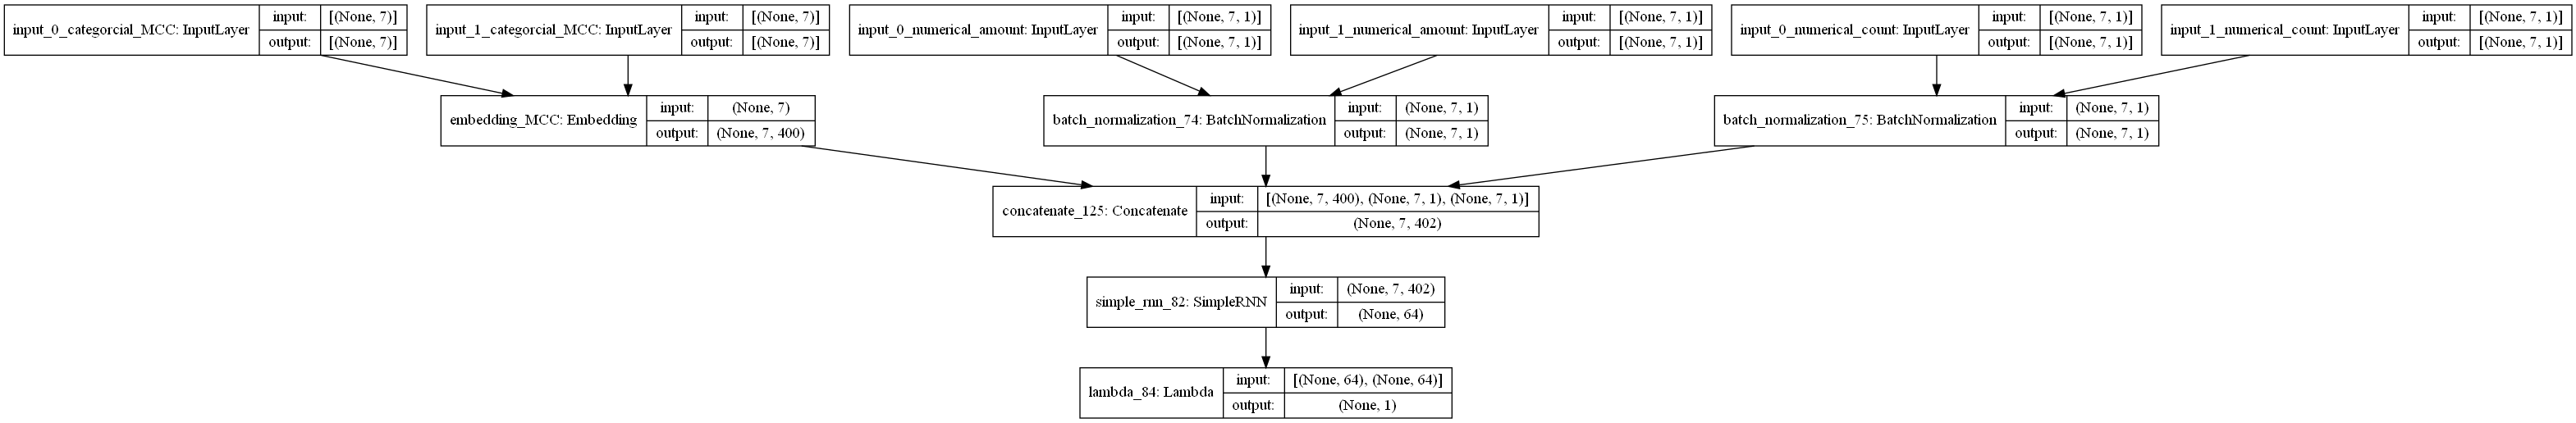

In [443]:
tf.keras.utils.plot_model(coles.model, to_file="model.png", show_shapes=True)

In [479]:
coles.model.input_shape

[(None, 7), (None, 7, 1), (None, 7, 1), (None, 7), (None, 7, 1), (None, 7, 1)]

In [459]:
a1 = np.asarray([[25,100,15,32,1,4,5],[9,8,7,6,5,4,3]])
a2 = np.asarray([np.asarray([[74.],[69.],[51.],[53.],[28.],[94.],[1]]),np.asarray([[74.],[1.],[3.],[5.],[8.],[4.],[9.]])])
a3 = np.asarray([np.asarray([[95.],[51.],[75.],[53.],[65.],[45.],[1]]),np.asarray([[68.],[57.],[24.],[35.],[85.],[96.],[74.]])])

b1 = np.asarray([[1,2,3,4,5,6,7],[8,5,2,7,4,1,3]])
b2 = np.asarray([[[50.],[12.],[35.],[121.],[85.],[6.],[1.]],[[98.],[87.],[65.],[54.],[32.],[21.],[7.]]])
b3 = np.asarray([[[12.],[23.],[45.],[56.],[78.],[89.],[85.]],[[74.],[41.],[12.],[23.],[36.],[65.],[58.]]])

In [461]:
history = coles.model.fit(x=[a1,a2,a3,b1,b2,b3],y=np.asarray([1,0]),batch_size=2,epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7776e-07 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 2.3618e-07 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 2.7092e-07 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6439e-07 - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6271e-07 - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 2.6045e-07 - accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 2.1926e-07 - accuracy: 0.0000e+00
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 1.1731e-07 - accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3217e-07 - accuracy: 0.0000e+00
Epoch 10/100
1/1 [==============================] - 0s 